In [1]:
###################################################################################
# Script to read OSTIA data
###################################################################################

# my own general packages
import sys
sys.path.append("/home/sryan/python/") # go to parent dir
from utils.plot_utils import finished_plot
from utils.datafun import celcius2fahrenheit,month_converter

# load project startup file with all relevant functions
exec(open('./startup.py').read())

# Load and process data

In [10]:
##################################################
# load data from 20007-2024
# ostia = xr.open_dataset('/vast/clidex/data/obs/SST/OSTIA/data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_multi-vars_84.97W-40.03W_20.02N-49.97N_2007-01-01-2024-12-31.nc')['analysed_sst']

#########################################################
# create a climatology
# ostia_clim_2010_2019 = ostia.sel(time=slice('2010-01-01','2019-12-31')).groupby('time.dayofyear').mean('time').compute()
# ostia_clim_2007_2024 = ostia.groupby('time.dayofyear').mean('time').compute()
# # save climatology
# ostia_clim_2007_2024.to_netcdf('/vast/clidex/data/obs/SST/OSTIA/baselines/ostia_baseline_2007_2024_85W-40W_20N-50N.nc')
# ostia_clim_2010_2019.to_netcdf('/vast/clidex/data/obs/SST/OSTIA/baselines/ostia_baseline_2010_2019_85W-40W_20N-50N.nc')
# # delete daily fields for memory purposes
# del ostia

# read saved files 
ostia_clim_2007_2024 = xr.open_dataset('/vast/clidex/data/obs/SST/OSTIA/baselines/ostia_baseline_2007_2024_85W-40W_20N-50N.nc')['analysed_sst']
ostia_clim_2010_2019 = xr.open_dataset('/vast/clidex/data/obs/SST/OSTIA/baselines/ostia_baseline_2010_2019_85W-40W_20N-50N.nc')['analysed_sst']


###########################################################
# read monthly mean data (created with CDO in command line)
ostia_mm = xr.open_dataset('/vast/clidex/data/obs/SST/OSTIA/data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_multi-vars_84.97W-40.03W_20.02N-49.97N_2007-01-01-2024-12-31_montly.nc')['analysed_sst']
ostia_mm_2025 = xr.open_dataset('/vast/clidex/data/obs/SST/OSTIA/data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_multi-vars_179.98W-179.98E_89.97S-89.97N_2025_monthly.nc')['analysed_sst']
# merge
ostia_mm = xr.concat((ostia_mm,ostia_mm_2025),dim='time')

In [11]:
###########################################################
# determine latest file available in folder

# List all entries in the directory
import os
filepath = '/vast/clidex/data/obs/SST/OSTIA/data/daily/'
files = os.listdir(filepath)

# Regular expression pattern to extract dates
import re
from datetime import datetime
date_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})\.nc")

# Extract dates and convert to datetime objects
dates = []
for filename in files:
    match = date_pattern.search(filename)
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        dates.append((filename, date_obj))

# Determine the latest date
latest_file, latest_date = max(dates, key=lambda x: x[1])

# open latest file
ostia_today = xr.open_dataset(filepath + latest_file)['analysed_sst']

In [12]:
# cut out region in current day file (global data)
lon_bnds = [min(ostia_clim_2007_2024.longitude),max(ostia_clim_2007_2024.longitude)]
lat_bnds = [min(ostia_clim_2007_2024.latitude),max(ostia_clim_2007_2024.latitude)]
ostia_today = ostia_today.sel(longitude=slice(*lon_bnds),latitude=slice(*lat_bnds))
#
#
#
#########################################################
# derive daily anomaly
doy = ostia_today.time.dt.dayofyear.values
ssta = ostia_today - ostia_clim_2010_2019.where(ostia_clim_2010_2019.dayofyear==doy,drop=True)
ssta_fahrenheit = (celcius2fahrenheit(ostia_today) 
                   - celcius2fahrenheit(ostia_clim_2010_2019.where(ostia_clim_2010_2019.dayofyear==doy,drop=True)))

# Plotting
## Anomaly map (this will go onto the main page, so you will likely use your own code to generate the tiles)

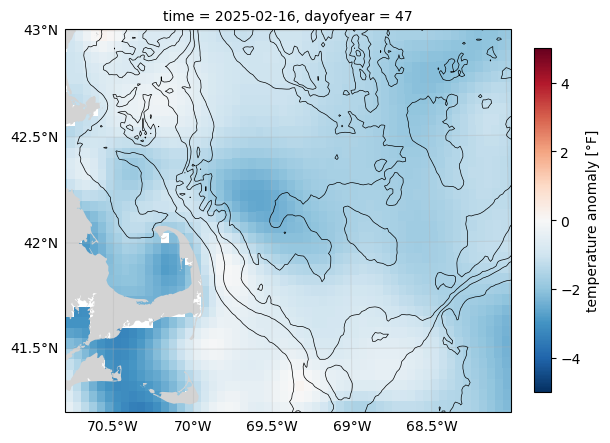

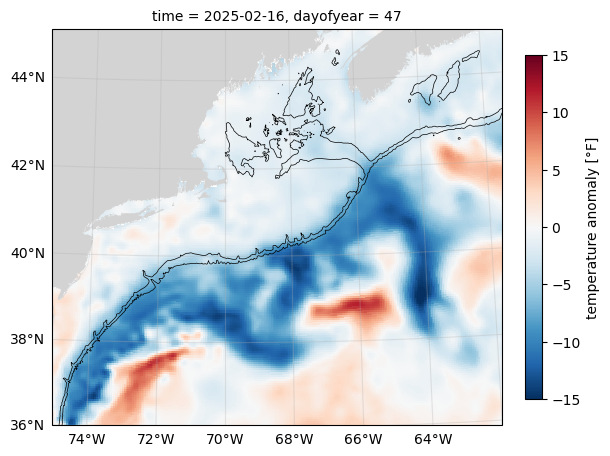

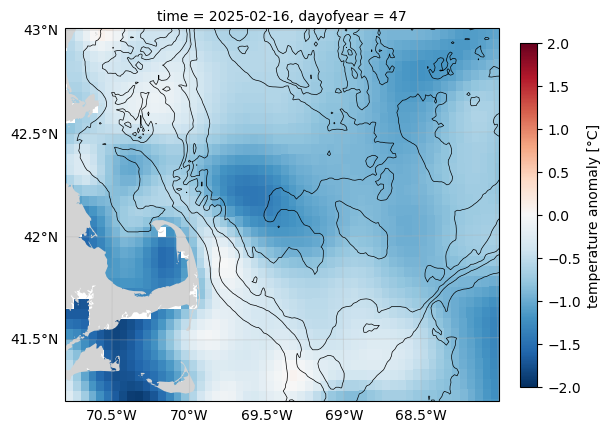

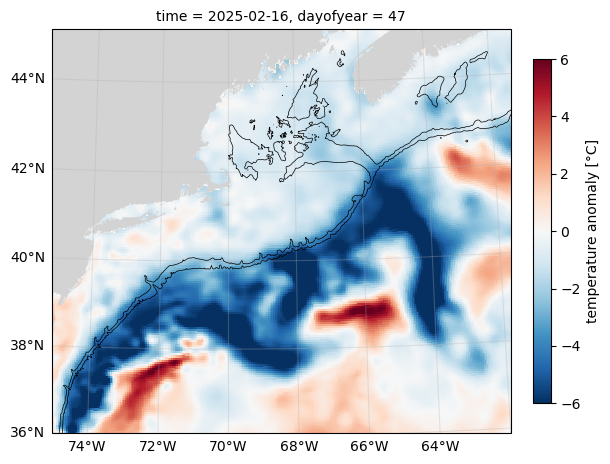

In [13]:
font_medium()
plt.close('all')

############### Fahrenheit ####################################
# zoom
fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
gl = plot_map(ax,[-70.8,-68,41.2,43],plotbathy=False)
cc=ssta_fahrenheit.plot(ax=ax,vmin=-5,vmax=5,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
plt.colorbar(cc,shrink=0.7,label='temperature anomaly [°F]')
ax.contour(bathy.x,bathy.y,bathy.z,levels=[-200,-150,-100,-50],colors='k',
           linestyles='solid',linewidths=0.5,transform=ccrs.PlateCarree())

# large-scale
fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
gl = plot_map(ax,[-75,-62,36,45],plotbathy=False,inc=2)
cc=ssta_fahrenheit.plot(ax=ax,vmin=-15,vmax=15,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
plt.colorbar(cc,shrink=0.7,label='temperature anomaly [°F]')
ax.contour(bathy.x,bathy.y,bathy.z,levels=[-1000,-200],colors='k',
           linestyles='solid',linewidths=0.5,transform=ccrs.PlateCarree())


############### Celcius ####################################
# zoom
fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
gl = plot_map(ax,[-70.8,-68,41.2,43],plotbathy=False)
cc=ssta.plot(ax=ax,vmin=-2,vmax=2,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
plt.colorbar(cc,shrink=0.7,label='temperature anomaly [°C]')
ax.contour(bathy.x,bathy.y,bathy.z,levels=[-200,-150,-100,-50],colors='k',
           linestyles='solid',linewidths=0.5,transform=ccrs.PlateCarree())

# large-scale
fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
gl = plot_map(ax,[-75,-62,36,45],plotbathy=False,inc=2)
cc=ssta.plot(ax=ax,vmin=-6,vmax=6,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
plt.colorbar(cc,shrink=0.7,label='temperature anomaly [°C]')
ax.contour(bathy.x,bathy.y,bathy.z,levels=[-1000,-200],colors='k',
           linestyles='solid',linewidths=0.5,transform=ccrs.PlateCarree())

## Annual Subplots

0
1


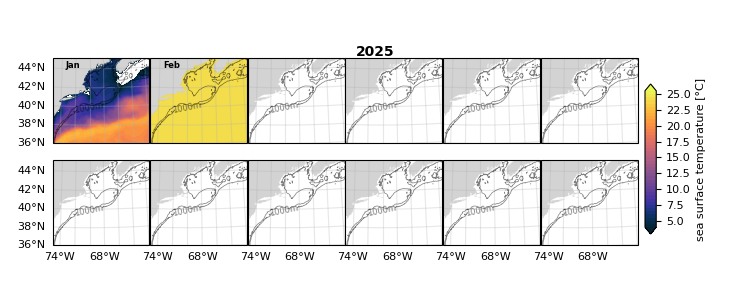

In [83]:
#####################################################
# prepare data
year = '2025'
ds = ostia_mm.sel(time=year)-273.15


###########################################
# plot
plt.close('all')
fs=8
plt.rcParams.update({'font.size': fs,'xtick.labelsize': fs, 'ytick.labelsize': fs})
# fonts_fbor_print()
fig,axh = plt.subplots(figsize=(7.5,3),nrows=2,ncols=6,subplot_kw = dict(projection=proj))
plt.subplots_adjust(wspace=0.01, hspace=-0.2,left=0.07,right=0.85) 
# cmap='Spectral_r'
vmax=4
vmin=26
levels=np.arange(4,26,0.5)

# loop through month
for i in range(12): # zip([0,1,2,3,4,5,6,9,10,11],range(10)):#  August and September 2022 are missing in the data (satellite issues)
    ax = axh.flatten()
    gl=plot_map(ax[i],[-75,-62,36,45],plotbathy=False,inc=2)
    if i<=len(ds.time)-1:
        cc0= ds.isel(time=i).plot.contourf(ax=ax[i],levels=levels,transform=ccrs.PlateCarree(),add_colorbar=False,
                                 vmin=vmin,vmax=vmax,cmap='cmo.thermal', extend='both')
        ax[i].text(-73.5,44,month_converter(ds['time.month'][i].values),
              transform=ccrs.PlateCarree(),fontweight='bold',fontsize=6)#(f"Month: {rss_sss['time.month'][i].values}")
    
    # add bathymtery    
    cc=ax[i].contour(bathy.x,bathy.y,bathy.z*(-1),levels=[100,1000],
                     transform=ccrs.PlateCarree(),colors='k',alpha=0.5,linewidths=0.5)
    manual_locations = [(-69, 41)]
    ax[i].clabel(cc,fontsize=6,fmt='%1dm',inline=True, manual=manual_locations)
    ax[i].set_title('')
    # modify labels
    if i in [1,2,3,4,5,7,8,9,10,11]: 
        gl.left_labels = False
    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
        
# add colorbar
cbaxes = fig.add_axes([0.86, 0.22, 0.015, 0.5]) 
cb = fig.colorbar(cc0,cax = cbaxes,shrink=0.7,label='sea surface temperature [°C]',extend='both') 
cb.set_ticks(np.arange(5,27.5,2.5))
cb.ax.yaxis.label.set_size(8)
plt.suptitle(year,y=0.85)
cb.minorticks_off()
# finished_plot(fig,f'./plots/SST/ostia_monthly_' + year + '.png')

In [ ]:
#######################################
# Anomaly subplots
#######################################

ds = ostia_mm.sel(time=year).groupby('time.month') - ostia_mm.sel(time=slice('2010','2019')).groupby('time.month').mean('time')

plt.close('all')
fs=8
plt.rcParams.update({'font.size': fs,'xtick.labelsize': fs, 'ytick.labelsize': fs})
# fonts_fbor_print()
fig,axh = plt.subplots(figsize=(7.5,3),nrows=2,ncols=6,subplot_kw = dict(projection=proj))
plt.subplots_adjust(wspace=0.01, hspace=-0.2,left=0.07,right=0.85) 
cmap='RdBu_r'
vmax=-5
vmin=5
levels=np.arange(-5,6,0.25)


for i in range(12): # zip([0,1,2,3,4,5,6,9,10,11],range(10)):#  August and September 2022 are missing in the data (satellite issues)
    ax = axh.flatten()
    gl=plot_map(ax[i],[-75,-62,36,45],plotbathy=False,inc=2)
    if i<=len(ds.time)-1:
        cc0= ds.isel(time=i).plot.contourf(ax=ax[i],levels=levels,transform=ccrs.PlateCarree(),add_colorbar=False,
                                 vmin=vmin,vmax=vmax,cmap=cmap, extend='both')
        # text
        ax[i].text(-73.5,44,month_converter(ds['time.month'][i].values),
                  transform=ccrs.PlateCarree(),fontweight='bold',fontsize=6)

    # add bathymtery    
    cc=ax[i].contour(bathy.x,bathy.y,bathy.z*(-1),levels=[100,1000],
                     transform=ccrs.PlateCarree(),colors='k',alpha=0.5,linewidths=0.5)
    manual_locations = [(-69, 41)]
    ax[i].clabel(cc,fontsize=6,fmt='%1dm',inline=True, manual=manual_locations)
    ax[i].set_title('')
    # modify labels
    if i in [1,2,3,4,5,7,8,9,10,11]: 
        gl.left_labels = False
    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
        
# add colorbar
cbaxes = fig.add_axes([0.86, 0.22, 0.015, 0.5]) 
cb = fig.colorbar(cc0,cax = cbaxes,shrink=0.7,label='sea surface temperature\n anomaly [°C]',extend='both') 
cb.ax.yaxis.label.set_size(8)
cb.set_ticks(np.arange(-5,7.5,2.5))
plt.suptitle(year,y=0.85)
cb.minorticks_off()
# finished_plot(fig,'./plots/SST/ostia_monthly_anomalies_2024.png')

## Timeseries box averages

Define regional boxed and average SST to derive timeseries.

1. Western Gulf of Maine
2. Outer Cape
3. RI profiles cluster
4. New Jersey cluster

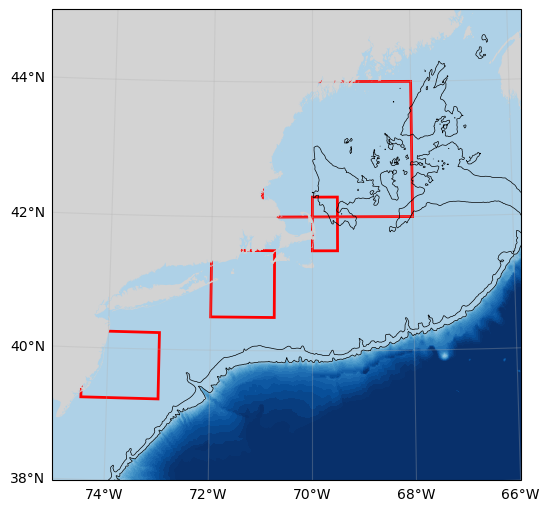

In [14]:
# map with boxes
fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
gl = plot_map(ax,[-75,-66,38,45],plotbathy=False,inc=2)
ax.contour(bathy.x,bathy.y,bathy.z,levels=[-1000,-200],colors='k',
           linestyles='solid',linewidths=0.5,transform=ccrs.PlateCarree())
ax.contourf(bathy.x,bathy.y,bathy.z*(-1),levels=np.arange(0,3000,100),cmap='Blues',transform=ccrs.PlateCarree(),extend='max')

# Create a Rectangle and add it to the plot
ax.add_patch(Rectangle((-70, 41.5), 0.5, 0.8,
                linewidth=2, edgecolor='red', facecolor='none',
                transform=ccrs.PlateCarree()))  # Ensure correct projection)
ax.add_patch(Rectangle((-71, 42), 3, 2,
                linewidth=2, edgecolor='red', facecolor='none',
                transform=ccrs.PlateCarree()))  # Ensure correct projection)
ax.add_patch(Rectangle((-72, 40.5), 1.25, 1,
                linewidth=2, edgecolor='red', facecolor='none',
                transform=ccrs.PlateCarree()))  # Ensure correct projection)
ax.add_patch(Rectangle((-74.5, 39.25), 1.5, 1,
                linewidth=2, edgecolor='red', facecolor='none',
                transform=ccrs.PlateCarree()))  # Ensure correct projection)


In [100]:
# plot timeseries
sst_oc = ostia.sel(longitude=slice(-70,-69.5),latitude=slice(41.5,42.3)).mean(('latitude','longitude'))
ssta_oc = sst_oc.groupby('time.dayofyear') - sst_oc.groupby('time.dayofyear').mean('time')

sst_GoM = ostia.sel(longitude=slice(-71,-68),latitude=slice(42,44)).mean(('latitude','longitude'))
ssta_GoM = sst_GoM.groupby('time.dayofyear') - sst_GoM.groupby('time.dayofyear').mean('time')

sst_RI = ostia.sel(longitude=slice(-72,-70.75),latitude=slice(40.5,41.5)).mean(('latitude','longitude'))
ssta_RI = sst_RI.groupby('time.dayofyear') - sst_RI.groupby('time.dayofyear').mean('time')

sst_NJ = ostia.sel(longitude=slice(-74.5,-73),latitude=slice(39.25,40.25)).mean(('latitude','longitude'))
ssta_NJ = sst_NJ.groupby('time.dayofyear') - sst_NJ.groupby('time.dayofyear').mean('time')

Since you are using plotly already, I wonder if it would be nice to plot the timeseries below also interactively which would allow the user to zoom in and out. Leaving that up to you, depending on how easy or not this is to implement. 

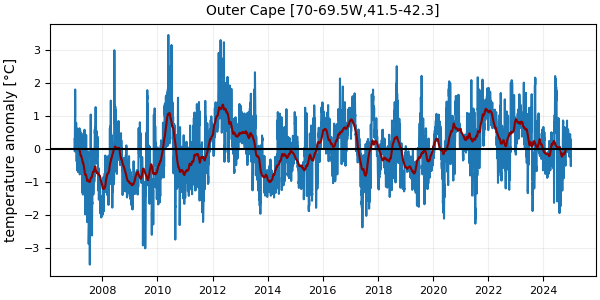

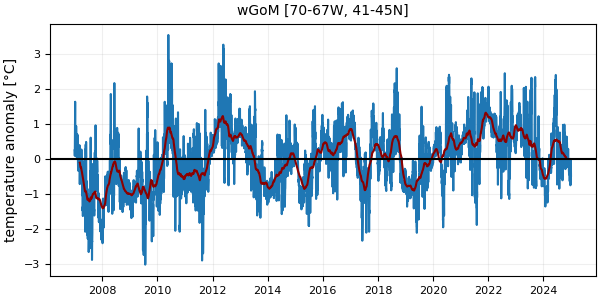

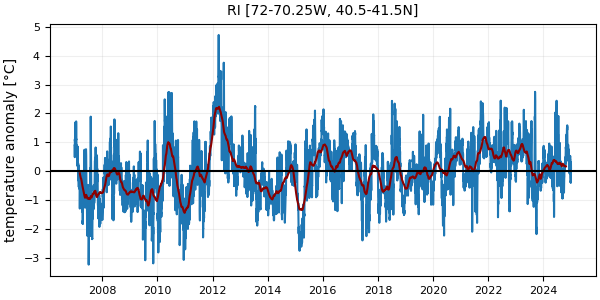

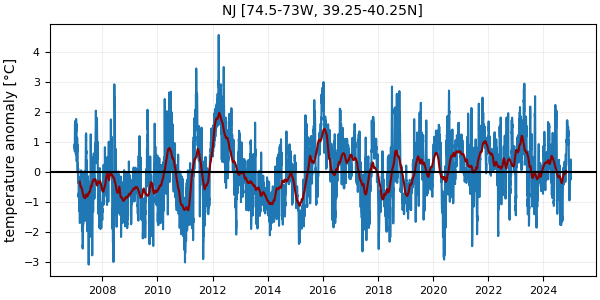

In [102]:
# Outer Cape
fig,ax = plt.subplots(figsize=(6,3),constrained_layout=True)
ssta_oc.plot()
ssta_oc.rolling(time=136,center=True).mean().plot(color='darkred')
ax.set_ylabel('temperature anomaly [°C]')
ax.set_xlabel('')
ax.axhline(0,linestyle='solid',color='k')
ax.set_title('Outer Cape [70-69.5W,41.5-42.3]')
ax.grid(alpha=0.2)

# Western Gulf of Maine
fig,ax = plt.subplots(figsize=(6,3),constrained_layout=True)
ssta_GoM.plot()
ssta_GoM.rolling(time=136,center=True).mean().plot(color='darkred')
# sst_oc_clim['analysed_sst'].rolling(time=136,center=True).mean().plot(color='hotpink')
ax.set_ylabel('temperature anomaly [°C]')
ax.set_xlabel('')
ax.axhline(0,linestyle='solid',color='k')
ax.set_title('wGoM [70-67W, 41-45N]')
ax.grid(alpha=0.2)

# Rhode ISland box
fig,ax = plt.subplots(figsize=(6,3),constrained_layout=True)
ssta_RI.plot()
ssta_RI.rolling(time=136,center=True).mean().plot(color='darkred')
ax.set_ylabel('temperature anomaly [°C]')
ax.set_xlabel('')
ax.axhline(0,linestyle='solid',color='k')
ax.set_title('RI [72-70.25W, 40.5-41.5N]')
ax.grid(alpha=0.2)

# New Jersey
fig,ax = plt.subplots(figsize=(6,3),constrained_layout=True)
ssta_NJ.plot()
ssta_NJ.rolling(time=136,center=True).mean().plot(color='darkred')
ax.set_ylabel('temperature anomaly [°C]')
ax.set_xlabel('')
ax.axhline(0,linestyle='solid',color='k')
ax.set_title('NJ [74.5-73W, 39.25-40.25N]')
ax.grid(alpha=0.2)


# 

# SMAP

- Monthly data downloaded with script on clidex /vast/clidex/data/obs/SSS/SMAP/SMAP_RSS_v6.0/data/download_RSS_SS_v06.0_monthly.sh

In [25]:
loncut = [-80,-55]
latcut = [35,46]

datapath = '/vast/clidex/data/obs/SSS/SMAP/SMAP_RSS_v6.0/data/'
rss_sss = xr.open_mfdataset(datapath + '/monthly/RSS_smap_SSS_L3_monthly_*_FNL_v06.0.nc').sel(lon=slice(*(np.array(loncut)+360)),
                                                           lat=slice(*latcut))['sss_smap'].load()

## Subplots

Saving ./plots/SSS/smap_monthly_2016.png
Saving ./plots/SSS/smap_monthly_2017.png
Saving ./plots/SSS/smap_monthly_2018.png
Saving ./plots/SSS/smap_monthly_2019.png
Saving ./plots/SSS/smap_monthly_2020.png
Saving ./plots/SSS/smap_monthly_2021.png
Saving ./plots/SSS/smap_monthly_2022.png
Saving ./plots/SSS/smap_monthly_2023.png
Saving ./plots/SSS/smap_monthly_2024.png


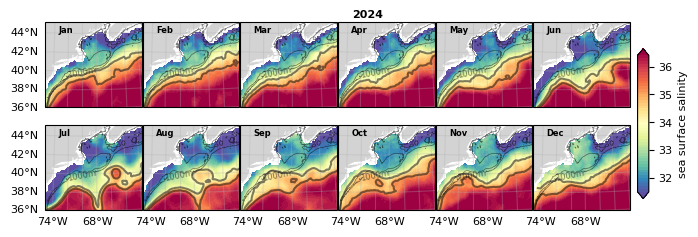

In [27]:
###################################################
## plot monthly fields as subplots - ZOOM OUT
###################################################

plot_region = [-75,-62,36,45] # GoM plus Slope

# loop through all years
for year in np.arange(2016,2025):
    ds = rss_sss.sel(time=str(year))
    
    plt.close('all')
    fs=8
    plt.rcParams.update({'font.size': fs,'xtick.labelsize': fs, 'ytick.labelsize': fs})
    # fonts_fbor_print()
    fig,axh = plt.subplots(figsize=(7.5,3),nrows=2,ncols=6,subplot_kw = dict(projection=proj))
    plt.subplots_adjust(wspace=0.01, hspace=-0.2,left=0.07,right=0.85) 
    cmap='Spectral_r'
    vmax=36.5
    vmin=31.5
    levels=np.arange(31.5,36.5,0.1)
    
    
    for i in range(12): # zip([0,1,2,3,4,5,6,9,10,11],range(10)):#  August and September 2022 are missing in the data (satellite issues)
        ax = axh.flatten()
        gl=plot_map(ax[i],plot_region,plotbathy=False,inc=2)
        cc0= ds.isel(time=i).plot.contourf(ax=ax[i],levels=levels,transform=ccrs.PlateCarree(),add_colorbar=False,
                                 vmin=vmin,vmax=vmax,cmap=cmap, extend='both')
        cc1 = ds.isel(time=i).plot.contour(ax=ax[i],levels=[34,35],transform=ccrs.PlateCarree(),add_colorbar=False,
                                 vmin=vmin,vmax=vmax,colors='k',alpha=0.5)
        # add bathymtery    
        cc=ax[i].contour(bathy.x,bathy.y,bathy.z*(-1),levels=[100,1000],
                         transform=ccrs.PlateCarree(),colors='k',alpha=0.5,linewidths=0.5)
        manual_locations = [(-69, 41)]
        ax[i].clabel(cc,fontsize=6,fmt='%1dm',inline=True, manual=manual_locations)
        # text
        ax[i].text(-73.5,44,month_converter(ds['time.month'][i].values),
                  transform=ccrs.PlateCarree(),fontweight='bold',fontsize=6)#(f"Month: {rss_sss['time.month'][i].values}")
        ax[i].set_title('')
        # modify labels
        if i in [1,2,3,4,5,7,8,9,10,11]: 
            gl.left_labels = False
        if i in [0,1,2,3,4,5]:
            gl.bottom_labels = False
            
    # add colorbar
    cbaxes = fig.add_axes([0.86, 0.22, 0.015, 0.5]) 
    cb = fig.colorbar(cc0,cax = cbaxes,shrink=0.7,label='sea surface salinity',extend='both') 
    cb.ax.yaxis.label.set_size(8)
    plt.suptitle(year,y=0.85)
    cb.set_ticks(np.arange(32,37))
    cb.minorticks_off()
    finished_plot(fig,f'./plots/SSS/smap_monthly_{year}.png')

## Timeseries

Text(0.5, 1.0, 'NJ [74.5-73W, 39.25-40.25N]')

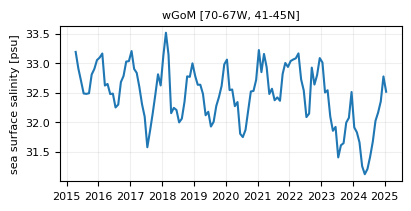

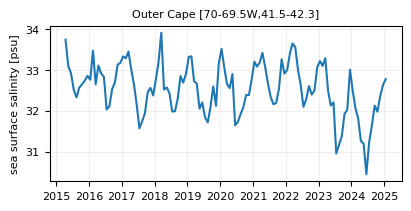

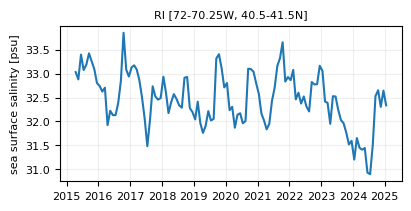

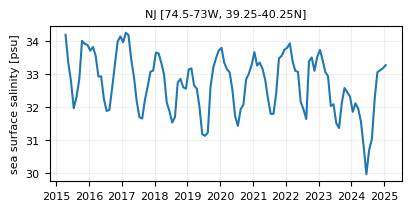

In [26]:
###################################################
## timeseries over boxes (same as SST)
# ###################################################
lonwGoM = [-71,-68]
latwGoM = [42,44]

lonoc = [-70,-69.5]
latoc = [41.5,42.3]

lonRI = [-72,-70.75]
latRI = [40.5,41.5]

lonNJ = [-74.5,-73]
latNJ = [39.25,40.25]


sss_box_wGoM = rss_sss.sel(lon=slice(*(np.array(lonwGoM)+360)),lat=slice(*latwGoM)).mean(('lat','lon'))
sss_box_wGoM_anom = (sss_box_wGoM.groupby('time.month')
                      - sss_box_wGoM.sel(time=slice('2016','2024')).groupby('time.month').mean('time'))

sss_box_oc = rss_sss.sel(lon=slice(*(np.array(lonoc)+360)),lat=slice(*latoc)).mean(('lat','lon'))
sss_box_oc_anom = (sss_box_oc.groupby('time.month')
                      - sss_box_oc.sel(time=slice('2016','2024')).groupby('time.month').mean('time'))

sss_box_RI = rss_sss.sel(lon=slice(*(np.array(lonRI)+360)),lat=slice(*latRI)).mean(('lat','lon'))
sss_box_RI_anom = (sss_box_RI.groupby('time.month')
                      - sss_box_RI.sel(time=slice('2016','2024')).groupby('time.month').mean('time'))

sss_box_NJ = rss_sss.sel(lon=slice(*(np.array(lonNJ)+360)),lat=slice(*latNJ)).mean(('lat','lon'))
sss_box_NJ_anom = (sss_box_NJ.groupby('time.month')
                      - sss_box_NJ.sel(time=slice('2016','2024')).groupby('time.month').mean('time'))



font_for_print()
fig,ax = plt.subplots(figsize=(4,2),constrained_layout=True)
sss_box_wGoM.plot()
ax.set_xlabel('')
ax.set_ylabel('sea surface salinity [psu]')
ax.grid(alpha=0.2)
ax.set_title('wGoM [70-67W, 41-45N]')

fig,ax = plt.subplots(figsize=(4,2),constrained_layout=True)
sss_box_oc.plot()
ax.set_xlabel('')
ax.set_ylabel('sea surface salinity [psu]')
ax.grid(alpha=0.2)
ax.set_title('Outer Cape [70-69.5W,41.5-42.3]')

fig,ax = plt.subplots(figsize=(4,2),constrained_layout=True)
sss_box_RI.plot()
ax.set_xlabel('')
ax.set_ylabel('sea surface salinity [psu]')
ax.grid(alpha=0.2)
ax.set_title('RI [72-70.25W, 40.5-41.5N]')

fig,ax = plt.subplots(figsize=(4,2),constrained_layout=True)
sss_box_NJ.plot()
ax.set_xlabel('')
ax.set_ylabel('sea surface salinity [psu]')
ax.grid(alpha=0.2)
ax.set_title('NJ [74.5-73W, 39.25-40.25N]')
# finished_plot(fig,f'./plots/SSS/smap_timeseries_monthly_ScotianS.png')
